In [1]:
from datetime import datetime
import osmnx as ox
import geopandas as gpd
import numpy as npm
import matplotlib
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rtree.index import Index as RTreeIndex
from shapely.geometry import Point
from shapely.geometry import LineString
from shapely.geometry import MultiLineString
from collections import deque
import datetime
import xml.etree.ElementTree as et 
from tqdm import tqdm
import networkx as nx
import json

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
CRS_NYC = 'EPSG:2263'
CRS_LATLON = 'EPSG:4326'
DATA_DIR = '../data'
EXPORTS_DIR = f'{DATA_DIR}/citibike/exports'
EDGE_COUNTS_DIR = f'{EXPORTS_DIR}/edge_counts'
WBR_TRIPS_DIR = f'{EXPORTS_DIR}/wbr_trips'

In [3]:
def peek(df):
    display(df.iloc[:3])
    print(len(df))
    
def hash_station_id(station_id):
    try:
        float_id = float(station_id)
        int_id = int(float(station_id))
        if int_id == float_id:
            return str(int_id)
        else:
            return str(float_id)
    except:
        return str(station_id)

In [4]:
LANES_DATE_STRING = '202101'

In [5]:
def graph_to_node_gdf(G):
    """Converts the given graph to a GeoDataFrame of its nodes."""
    nodes, data = zip(*G.nodes(data=True))
    geom = [Point(node[0], node[1]) for node in nodes]
    nodes_gdf = gpd.GeoDataFrame(data,
                                 index=list(nodes),
                                 crs=CRS_LATLON,
                                 geometry=geom)
    return nodes_gdf

In [6]:
def graph_to_edge_gdf(G):
    """Converts the given graph to a GeoDataFrame of its edges."""
    u, v, data = zip(*G.edges(data=True))
    edges = list(zip(u, v))
    geom = [
        LineString((Point(edge[0][0],
                          edge[0][1]), Point(edge[1][0], edge[1][1])))
        for edge in edges
    ]
    edge_index = [(edge[0] + edge[1]) for edge in edges]
    edges_gdf = gpd.GeoDataFrame(data,
                                 index=edge_index,
                                 crs=CRS_LATLON,
                                 geometry=list(geom))
    edges_gdf['length'] = edges_gdf.geometry.length
    return edges_gdf

In [7]:
lanes_mg = nx.read_shp(f'{DATA_DIR}/geo/lanes/' +
                       f'{LANES_DATE_STRING}_lanes_citibike_area.shp')
lanes_mg.graph['crs'] = CRS_LATLON

# Select only the largest weakly connected component.
lanes_wcc = max(nx.weakly_connected_components(lanes_mg), key=len)
lanes_mg = lanes_mg.subgraph(lanes_wcc)

# Remove directionality due to incorrect infeasible paths!j
lanes_g = nx.Graph(lanes_mg)

In [8]:
node_gdf = graph_to_node_gdf(lanes_g)
edge_gdf = graph_to_edge_gdf(lanes_g)

In [105]:
date_strings = [
  '201601',
  '201602',
  '201603',
  '201604',
  '201605',
  '201606',
  '201607',
  '201608',
  '201609',
  '201610',
  '201611',
  '201612',
  '201701',
  '201702',
  '201703',
  '201704',
  '201705',
  '201706',
  '201707',
  '201708',
  '201709',
  '201710',
  '201711',
  '201712',
  '201801',
  '201802',
  '201803',
  '201804',
  '201805',
  '201806',
  '201807',
  '201808',
  '201809',
  '201810',
  '201811',
  '201812',
  '201901',
  '201902',
  '201903',
  '201904',
  '201905',
  '201906',
  '201907',
  '201908',
  '201909',
  '201910',
  '201911',
  '201912',
  '202001',
  '202002',
  '202003',
  '202004',
  '202005',
  '202006',
  '202007',
  '202008',
  '202009',
  '202010',
  '202011',
  '202012',
]

In [106]:
wbr_dfs = [pd.read_csv(f'{WBR_TRIPS_DIR}/{s}_trips.csv') for s in date_strings]

In [99]:
def plot_wbr(wbd_df):
    start_geometry = [Point(xy) for xy in zip(wbr_df['start_lon'], wbr_df['start_lat'])]
    end_geometry = [Point(xy) for xy in zip(wbr_df['end_lon'], wbr_df['end_lat'])]
    wbr_start_gdf = gpd.GeoDataFrame({}, geometry=start_geometry, crs=CRS_LATLON).drop_duplicates()
    wbr_end_gdf = gpd.GeoDataFrame({}, geometry=end_geometry, crs=CRS_LATLON).drop_duplicates()

    fig, ax = plt.subplots(figsize=(15, 15))
    edge_gdf.plot(ax=ax, color='#555', zorder=1)
    wbr_start_gdf.plot(ax=ax, color='C0', alpha=0.5)
    wbr_end_gdf.plot(ax=ax, color='C1', alpha=0.5)
    ax.set_facecolor('#777')

In [100]:
wbr_dfs[0]

,trip_duration,start_time,stop_time,start_station_id,start_station_name,start_lat,start_lon,end_station_id,end_station_name,end_lat,end_lon,bike_id,user_type,birth_year,gender,od_pair
0,1830,2017-01-21 22:22:19,2017-01-21 22:52:50,128,MacDougal St & Prince St,40.727103,-74.002971,3107,Bedford Ave & Nassau Ave,40.723117,-73.952123,25643,Subscriber,1985.0,1,"('128', '3107')"
1,1374,2017-01-14 13:36:21,2017-01-14 13:59:16,128,MacDougal St & Prince St,40.727103,-74.002971,532,S 5 Pl & S 4 St,40.710451,-73.960876,16276,Customer,1973.0,1,"('128', '532')"
2,1404,2017-01-19 18:28:17,2017-01-19 18:51:42,151,Cleveland Pl & Spring St,40.722104,-73.997249,2002,Wythe Ave & Metropolitan Ave,40.716887,-73.963198,19582,Subscriber,1992.0,1,"('151', '2002')"
3,3100,2017-01-21 15:04:09,2017-01-21 15:55:50,151,Cleveland Pl & Spring St,40.722104,-73.997249,3112,Milton St & Franklin St,40.729060,-73.957790,25418,Customer,NaN,0,"('151', '3112')"
4,3140,2017-01-21 15:04:14,2017-01-21 15:56:34,151,Cleveland Pl & Spring St,40.722104,-73.997249,3112,Milton St & Franklin St,40.729060,-73.957790,15504,Customer,NaN,0,"('151', '3112')"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1108,1497,2017-01-27 11:49:38,2017-01-27 12:14:36,532,S 5 Pl & S 4 St,40.710451,-73.960876,531,Forsyth St & Broome St,40.718939,-73.992663,15882,NaN,1979.0,2,"('532', '531')"
1109,1444,2017-01-27 11:50:05,2017-01-27 12:14:10,532,S 5 Pl & S 4 St,40.710451,-73.960876,531,Forsyth St & Broome St,40.718939,-73.992663,25557,NaN,1982.0,1,"('532', '531')"
1110,703689,2017-01-27 13:35:18,2017-02-04 17:03:27,532,S 5 Pl & S 4 St,40.710451,-73.960876,531,Forsyth St & Broome St,40.718939,-73.992663,21188,Customer,NaN,0,"('532', '531')"
1111,2113,2017-01-03 17:45:43,2017-01-03 18:20:56,536,1 Ave & E 30 St,40.741444,-73.975361,3070,McKibbin St & Manhattan Ave,40.705109,-73.944073,25898,Subscriber,1992.0,2,"('536', '3070')"


In [111]:
wbr_dt_df = pd.concat(wbr_dfs)
wbr_dt_df['datetime'] = pd.to_datetime(wbr_dt_df['start_time'])
wbr_dt_df['date'] = pd.to_datetime(wbr_dt_df['start_time']).dt.date
wbr_dt_df = wbr_dt_df.sort_values(by=['date'])
wbr_dt_df = wbr_dt_df.groupby(by=['date']).agg({'od_pair': 'count'})
wbr_dt_df = wbr_dt_df.rename(columns={'od_pair': 'count'})

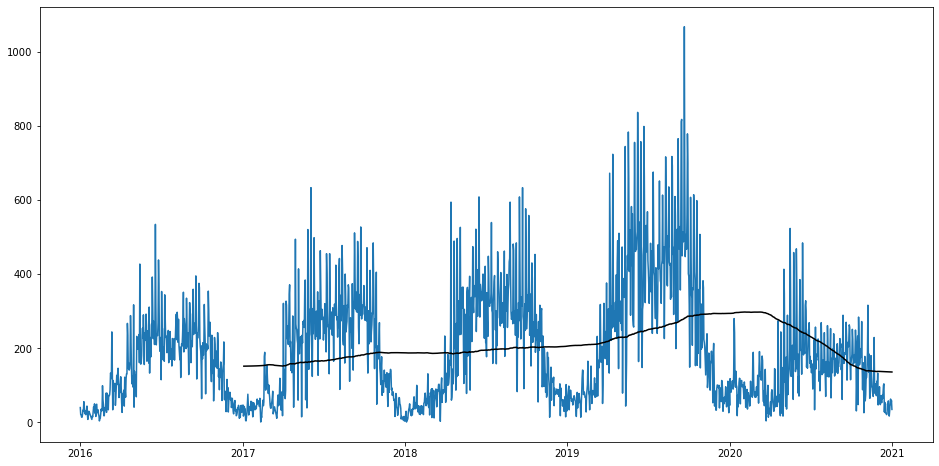

In [116]:
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(wbr_dt_df['count'])
ax.plot(wbr_dt_df['count'].rolling(window=365).mean(), color='#000')
plt.show()